In [1]:
#Prepare dataset that has profiles of different lengths - Feb 2022
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import gsw
import colorcet as cc

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '/home1/datahome/epauthen/NaN_profiles_gestion/cartopy_shapefiles'
os.getcwd()


'/home1/datahome/epauthen/All_depth'

In [2]:
#Map of TS
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([-80, -30, 23, 47.5])
subplot_kw = {'projection': proj, 'extent': extent}

#To get the bathymetry
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
ds_bat = ds_bat.where(ds_bat.LONGITUDE<(-40),-1500)
ds_bat = ds_bat.where(((ds_bat.LONGITUDE>(-68)) & (ds_bat.LATITUDE>(30)) & (ds_bat.LATITUDE<(40)))==False,-1500)
kw = {'levels':[0,-1000], 'colors':['black'],'linewidths':[1],'linestyles':['solid']}

In [3]:
ds = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_all_depth_clean.nc")
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 158294, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 ...
    latitude         (N_PROF) float64 ...
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables:
    TEMP_SURF        (N_PROF, depth) float64 ...
    PSAL_SURF        (N_PROF, depth) float64 ...
    TEMP_INTERP      (N_PROF, depth) float64 ...
    PSAL_INTERP      (N_PROF, depth) float64 ...
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...

In [4]:
lats = ds.latitude
lons = ds.longitude
dates = ds.time
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 158294, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 ...
    latitude         (N_PROF) float64 ...
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables:
    TEMP_SURF        (N_PROF, depth) float64 ...
    PSAL_SURF        (N_PROF, depth) float64 ...
    TEMP_INTERP      (N_PROF, depth) float64 ...
    PSAL_INTERP      (N_PROF, depth) float64 ...
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...

In [5]:
%%time
#BATHYMETRY
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
res_lin = ds_bat.interp(LATITUDE=lats,LONGITUDE=lons,method = 'linear')['bathymetry'].values
ds = ds.assign(variables={"bathy": (('N_PROF'), res_lin)})

CPU times: user 60 ms, sys: 44 ms, total: 104 ms
Wall time: 183 ms


In [6]:
%%time
#MDT
ds_mdt = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/data_remote_sensing/MDT/mdt-cnes-cls18-global.nc')
ds_mdt = ds_mdt.assign_coords(lon180=(((ds_mdt.longitude + 180) % 360) - 180))  
ds_mdt['longitude'] = ds_mdt.lon180 
ds_mdt = ds_mdt.squeeze()

res = ds_mdt.interp(latitude=lats,longitude=lons,method = 'linear')['mdt'].values
ds = ds.assign(variables={"MDT": (('N_PROF'), res)})

CPU times: user 220 ms, sys: 24 ms, total: 244 ms
Wall time: 530 ms


In [7]:
%%time
#SST
path = '/home/datawork-lops-bluecloud/osnet/data_remote_sensing/SST/SST_Gulf_Stream/'
ds_sst = xr.open_mfdataset(path + '/*.nc')

spatial_domain = {"lon":[-80, -30],
                 "lat": [23, 50]}
ds_sst = ds_sst.sel(lon=slice(spatial_domain['lon'][0], spatial_domain['lon'][1]),
                    lat=slice(spatial_domain['lat'][0], spatial_domain['lat'][1]))
ds_sst

CPU times: user 5.16 s, sys: 2.19 s, total: 7.35 s
Wall time: 22.4 s


<xarray.Dataset>
Dimensions:               (time: 9861, lat: 540, lon: 1000)
Coordinates:
  * time                  (time) datetime64[ns] 1993-01-01T12:00:00 ... 2019-...
  * lat                   (lat) float32 23.02 23.08 23.12 ... 49.88 49.92 49.97
  * lon                   (lon) float32 -79.97 -79.93 -79.88 ... -30.08 -30.02
Data variables:
    analysed_sst          (time, lat, lon) float32 dask.array<chunksize=(31, 540, 1000), meta=np.ndarray>
    analysis_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(31, 540, 1000), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                     CF-1.5, Unidata Observation Dataset v1.0
    title:                           ESA SST CCI OSTIA L4 product
    summary:                         OSTIA L4 product from the ESA SST CCI pr...
    references:                      http://www.esa-sst-cci.org
    institution:                     ESACCI
    history:                         Created using OSTIA reanalysis system v3.0
    ...                              ...
    publisher_name:                  ESACCI
    publisher_url:                   http://www.esa-sst-cci.org
    publisher_email:                 science.leader@esa-SST-cci.org
    processing_level:                L4
    cdm_data_type:                   grid
    product_specification_version:   SST_CCI-PSD-UKMO-201-Issue-H

In [8]:
%%time

res = ds_sst.sel(dict(lat=lats, lon=lons, time=dates), method='nearest')['analysed_sst'].values-273.15
ds = ds.assign(variables={"SST": (('N_PROF'), res)})

CPU times: user 6.59 s, sys: 14.3 s, total: 20.9 s
Wall time: 3min 6s


In [9]:
#Intermediate save
ds.to_netcdf("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_alldepth_1993-2019_v1.nc")

In [ ]:
#Reload
#ds = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_alldepth_1993-2019_v1.nc")
#lats = ds.latitude
#lons = ds.longitude
#dates = ds.time
#ds

In [10]:
%%time
#SLA
path = '/home/datawork-lops-bluecloud/osnet/data_remote_sensing/SLA/SLA_Gulf_Stream/'
ds_sla = xr.open_mfdataset(path + '*.nc')
ds_sla = ds_sla.assign_coords(lon180=(((ds_sla.longitude + 180) % 360) - 180))  
ds_sla['longitude'] = ds_sla.lon180
ds_sla = ds_sla.sortby('longitude')
ds_sla

CPU times: user 764 ms, sys: 212 ms, total: 976 ms
Wall time: 5.04 s


<xarray.Dataset>
Dimensions:    (time: 9861, longitude: 240, latitude: 148, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
  * latitude   (latitude) float32 18.12 18.38 18.62 18.88 ... 54.38 54.62 54.88
  * longitude  (longitude) float32 -84.88 -84.62 -84.38 ... -25.62 -25.38 -25.12
  * nv         (nv) int32 0 1
    lon180     (longitude) float32 -84.88 -84.62 -84.38 ... -25.62 -25.38 -25.12
Data variables:
    crs        (time, longitude, latitude) float64 dask.array<chunksize=(365, 240, 148), meta=np.ndarray>
    lat_bnds   (time, latitude, nv, longitude) float32 dask.array<chunksize=(365, 148, 2, 240), meta=np.ndarray>
    lon_bnds   (time, longitude, nv, latitude) float32 dask.array<chunksize=(365, 240, 2, 148), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(365, 148, 240), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1993-01-01T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [11]:
%%time
res = ds_sla.sel(dict(latitude=lats, longitude=lons, time=dates), method='nearest')


CPU times: user 9.14 s, sys: 24 ms, total: 9.17 s
Wall time: 9.42 s


In [12]:
%%time
ds = ds.assign(variables={"SLA": (('N_PROF'), res['sla'].values)}) 
ds = ds.assign(variables={"UGOS": (('N_PROF'), res['ugos'].values)}) 
ds = ds.assign(variables={"VGOS": (('N_PROF'), res['vgos'].values)}) 
ds = ds.assign(variables={"UGOSA": (('N_PROF'), res['ugosa'].values)}) 
ds = ds.assign(variables={"VGOSA": (('N_PROF'), res['vgosa'].values)}) 


CPU times: user 1.44 s, sys: 7.77 s, total: 9.21 s
Wall time: 54.6 s


In [13]:
#Drop Profiles with NaN in input
ds = ds.dropna(dim = 'N_PROF',how='any', subset = {'SLA','UGOS','VGOS','UGOSA','VGOSA','SST','MDT','bathy'})
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 138876, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 -67.27 -66.88 -66.67 ... -64.74 -66.1
    latitude         (N_PROF) float64 41.23 40.98 41.23 ... 41.9 31.8 41.88
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] 1994-02-24T00:24:00 ... 2000-02-...
Dimensions without coordinates: N_PROF
Data variables: (12/14)
    TEMP_SURF        (N_PROF, depth) float64 ...
    PSAL_SURF        (N_PROF, depth) float64 ...
    TEMP_INTERP      (N_PROF, depth) float64 ...
    PSAL_INTERP      (N_PROF, depth) float64 ...
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...
    ...               ...
    SST              (N_PROF) float32 4.23 5.61 5.4 4.93 ... 4.98 20.11 4.54
    SLA              (N_PROF) float64 -0.0869 -0.0843 -0.0698 ... 0.0594 -0.025
    UGOS             (N_PROF) float64 -0.0409 -0.0882 ... -0.0154 -0.1051
    VGOS             (N_PROF) float64 -0.0719 -0.0595 0.0141 ... 0.0777 -0.1644
    UGOSA            (N_PROF) float64 0.0104 0.001 -0.0275 ... 0.0272 -0.1364
    VGOSA            (N_PROF) float64 -0.0283 0.007 0.1085 ... 0.0733 -0.0896

In [14]:
# compute day of year, cos and sinus
day = np.array(pd.DatetimeIndex(ds['time'].data).dayofyear).astype(np.int32)
ds = ds.assign(variables={"dayOfYear": (('N_PROF'), day)})
d = 1/365
cos_day = np.cos(np.pi*2*d*ds['dayOfYear'].data)
sin_day = np.sin(np.pi*2*d*ds['dayOfYear'].data)
ds = ds.assign(variables={"cos_day": (('N_PROF'), cos_day)})
ds = ds.assign(variables={"sin_day": (('N_PROF'), sin_day)})

In [15]:
#Compute MLD
SA = gsw.SA_from_SP(ds['PSAL_INTERP'], ds['depth'], ds['longitude'], ds['latitude'])
CT = gsw.CT_from_t(SA, ds['TEMP_INTERP'], ds['depth'])
sigma0 = gsw.sigma0(SA,CT)
ds = ds.assign(variables={"SIG": (('N_PROF','depth'), sigma0.data)})
#
sig_diff = ds.SIG - ds.SIG.sel(depth = 10)-0.03
MLD = ds['depth'].where(sig_diff>0).min(dim='depth')
ds = ds.assign(MLD = MLD)


In [16]:
#MLD mask
def get_mask(mld):
    mask = np.sign(np.array(ds.depth)-mld)
    return np.where(mask<0, 0, mask)

get_mask_vect = np.vectorize(get_mask, signature='()->(k)')
MLD_mask = get_mask_vect(ds.MLD.data)

MLD_mask = np.nan_to_num(MLD_mask)
ds = ds.assign(variables={"MLD_mask": (('N_PROF','depth'), MLD_mask.data)})

In [17]:
# create depth mask
mask_depthT = 1-np.isnan(ds.TEMP_INTERP).astype(int)
mask_depthS = 1-np.isnan(ds.PSAL_INTERP).astype(int)
ds = ds.assign(mask_depthT=mask_depthT)
ds = ds.assign(mask_depthS=mask_depthS)
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 138876, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 -67.27 -66.88 -66.67 ... -64.74 -66.1
    latitude         (N_PROF) float64 41.23 40.98 41.23 ... 41.9 31.8 41.88
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] 1994-02-24T00:24:00 ... 2000-02-...
Dimensions without coordinates: N_PROF
Data variables: (12/22)
    TEMP_SURF        (N_PROF, depth) float64 ...
    PSAL_SURF        (N_PROF, depth) float64 ...
    TEMP_INTERP      (N_PROF, depth) float64 4.43 4.43 4.43 4.43 ... nan nan nan
    PSAL_INTERP      (N_PROF, depth) float64 32.87 32.87 32.87 ... nan nan nan
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...
    ...               ...
    sin_day          (N_PROF) float64 0.8115 0.8115 0.8115 ... 0.747 0.747 0.747
    SIG              (N_PROF, depth) float64 26.05 26.05 26.05 ... nan nan nan
    MLD              (N_PROF) float64 nan 19.0 30.0 35.0 ... nan 12.0 110.0 14.0
    MLD_mask         (N_PROF, depth) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_depthT      (N_PROF, depth) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    mask_depthS      (N_PROF, depth) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0

In [18]:
depth_prof = ds.depth.data[np.argmin(ds.mask_depthT.data, axis=1)-1]
ds = ds.assign(variables={"depth_prof": (('N_PROF'), depth_prof)})
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 138876, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 -67.27 -66.88 -66.67 ... -64.74 -66.1
    latitude         (N_PROF) float64 41.23 40.98 41.23 ... 41.9 31.8 41.88
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] 1994-02-24T00:24:00 ... 2000-02-...
Dimensions without coordinates: N_PROF
Data variables: (12/23)
    TEMP_SURF        (N_PROF, depth) float64 ...
    PSAL_SURF        (N_PROF, depth) float64 ...
    TEMP_INTERP      (N_PROF, depth) float64 4.43 4.43 4.43 4.43 ... nan nan nan
    PSAL_INTERP      (N_PROF, depth) float64 32.87 32.87 32.87 ... nan nan nan
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...
    ...               ...
    SIG              (N_PROF, depth) float64 26.05 26.05 26.05 ... nan nan nan
    MLD              (N_PROF) float64 nan 19.0 30.0 35.0 ... nan 12.0 110.0 14.0
    MLD_mask         (N_PROF, depth) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_depthT      (N_PROF, depth) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    mask_depthS      (N_PROF, depth) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    depth_prof       (N_PROF) int64 45 70 70 80 45 1950 ... 1200 65 80 1150 90

In [19]:
ds.to_netcdf("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_alldepth_1993-2019.nc")

In [20]:
#tests
ds = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_cora_raw/CORA_alldepth_1993-2019.nc")
ds

<xarray.Dataset>
Dimensions:          (N_PROF: 138876, depth: 114)
Coordinates:
    longitude        (N_PROF) float64 ...
    latitude         (N_PROF) float64 ...
  * depth            (depth) int64 0 1 2 3 4 5 ... 3750 3800 3850 3900 3950 4000
    time             (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables: (12/23)
    TEMP_SURF        (N_PROF, depth) float64 ...
    PSAL_SURF        (N_PROF, depth) float64 ...
    TEMP_INTERP      (N_PROF, depth) float64 ...
    PSAL_INTERP      (N_PROF, depth) float64 ...
    DC_REFERENCE     (N_PROF) |S8 ...
    PLATFORM_NUMBER  (N_PROF) |S8 ...
    ...               ...
    SIG              (N_PROF, depth) float64 ...
    MLD              (N_PROF) float64 ...
    MLD_mask         (N_PROF, depth) float64 ...
    mask_depthT      (N_PROF, depth) int64 ...
    mask_depthS      (N_PROF, depth) int64 ...
    depth_prof       (N_PROF) int64 ...

In [21]:
#Verification
#np.sum(ds.mask_depthT-ds.mask_depthS)
#np.sum(np.isnan(ds.mask_depthS))
#np.sum(np.isnan(ds.SLA))
np.sum(np.isnan(ds.VGOSA))

<xarray.DataArray 'VGOSA' ()>
array(0)

Text(0.0, 1.0, 'a) SST')

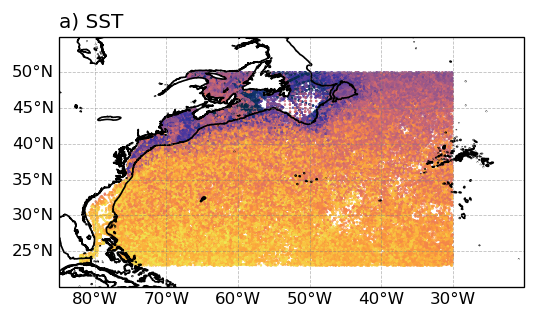

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
cm = cc.cm["rainbow"]
ax.scatter(ds.longitude,ds.latitude,c = ds.SST,cmap = cmocean.cm.thermal,s = .2)
ax.set_xlim([-85,-20])
ax.set_ylim([20,55])
ds_bat['bathymetry'].plot.contour(**kw,ax = ax)
#ax.add_feature(land_feature, edgecolor='black')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('a) SST',loc = 'left')

In [ ]:
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
cm = cc.cm["rainbow"]
ax.scatter(ds.longitude,ds.latitude,c = ds.TEMP_INTERP.isel(depth = 113),cmap = cmocean.cm.thermal,s = .2)
ax.set_xlim([-82,-20])
ax.set_ylim([20,55])
ds_bat['bathymetry'].plot.contour(**kw,ax = ax)
#ax.add_feature(land_feature, edgecolor='black')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('a) ',loc = 'left')
